In [1]:
import math
import numpy as np
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
from haqc.solutions.solutions import compute_max_cut_brute_force, compute_distance
from matplotlib.colors import LinearSegmentedColormap

from concurrent.futures import ProcessPoolExecutor, as_completed
from qiskit import QuantumCircuit, Aer, execute
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut
from qiskit.opflow import AerPauliExpectation, PauliSumOp
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter, ParameterVector

# Custom imports
from haqc.parallel.landscape_parallel import parallel_computation_n_layers_fixed
from haqc.generators.graph_instance import create_graphs_from_all_sources, GraphInstance
from haqc.generators.parameter import get_optimal_parameters
from haqc.plot.landscape import plot_landscape
from haqc.exp_utils import str2bool, to_snake_case, make_temp_directory, check_boto3_credentials
from haqc.parallel.landscape_parallel import parallel_computation


df = pd.read_csv("../data/optimal-parameters.csv")


# Set a global style
plt.style.use('default')

node_size = 12
# WARNING THIS SIZE DOES CHANGE RUNTIME
MESH_SIZE = 400

In [2]:
with open('landscape_data_storage.pkl', 'rb') as f:
    d_landscape = pickle.load(f)
print(d_landscape.keys())

dict_keys(['Graph_1_Uniform Random', 'Graph_2_Power Law Tree', 'Graph_3_Watts-Strogatz small world', 'Graph_4_Geometric', 'Graph_5_Nearly Complete BiPartite', 'Graph_6_3-Regular Graph', 'Graph_7_4-Regular Graph', 'Graph_8_4-Regular Graph Fixed Weights'])


# Looking at $p=1$ landscapes by source


For $QAOA_{1}$ applied to MaxCut on any triangle-free graph, the optimal angles maximizing $C$ (or, equivalently, maximizing $C/m$) satisfy the following:

- For a $D$-regular triangle-free graph, the unique smallest positive optimal pair of angles is

  $$
  (\gamma^*, \beta^*) := \left( \arctan \frac{1}{\sqrt{D - 1}}, \frac{\pi}{8} \right),
  $$

  for $D \geq 2$ (i.e., no other optimal pair $(\gamma, \beta)$ exists with $0 < \gamma \leq \gamma^*$ or $0 < \beta \leq \beta^*$).

  All optimal angles are periodic in $\gamma, \beta$ with periodicity depending on $D$:

  - If $D$ is even, there is a second independent pair of optimal angles given by $(-\gamma^*, -\beta^*)$, independent in the sense that all optimal angles are generated from these two pairs as

    $$
    (\gamma^* + a\pi, \beta^* + b\frac{\pi}{2}), \quad (-\gamma^* + c\pi, -\beta^* + d\frac{\pi}{2}), \quad a, b, c, d \in \mathbb{Z}.
    $$

  - Else if $D$ is odd, there are four independent pairs of optimal angles $(\gamma^*, \beta^*)$, $(-\gamma^*, -\beta^*)$, $(\pi - \gamma^*, \beta^*)$, and $(\pi + \gamma^*, -\beta^*)$, and all optimal angles are generated from one of these pairs, denoted $(\gamma', \beta')$, as

    $$
    (\gamma' + a2\pi, \beta' + b\frac{\pi}{2}), \quad a, b \in \mathbb{Z}.
    $$

- For an arbitrary triangle-free graph with maximum vertex degree $D_G$ and minimum vertex degree $D_{\min}$, the smallest positive optimal angles $\gamma^*, \beta^*$ in $[0, \pi/2]$ satisfy

  $$
  \arctan \frac{1}{\sqrt{D_G - 1}} \leq \gamma^* \leq \arctan \frac{1}{\sqrt{D_{\min} - 1}}, \quad \beta^* = \frac{\pi}{8}.
  $$

  Given such a pair, the angles $(-\gamma^*, -\beta^*)$ are also optimal, and both pairs are $2\pi$-periodic in the first argument and $\pi/2$-periodic in the second, with respect to optimality.

The theorem implies the smallest optimal angles are $(\pi/4, \pi/8)$ and $(0.6155, \pi/8)$ for 2-regular and 3-regular triangle-free graphs.

Cited from: [Zhou, L., Wang, S., Choi, S., Pichler, H., & Lukin, M. D. (2018). Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices. *Physical Review A*, 97(2), 022304.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.97.022304)


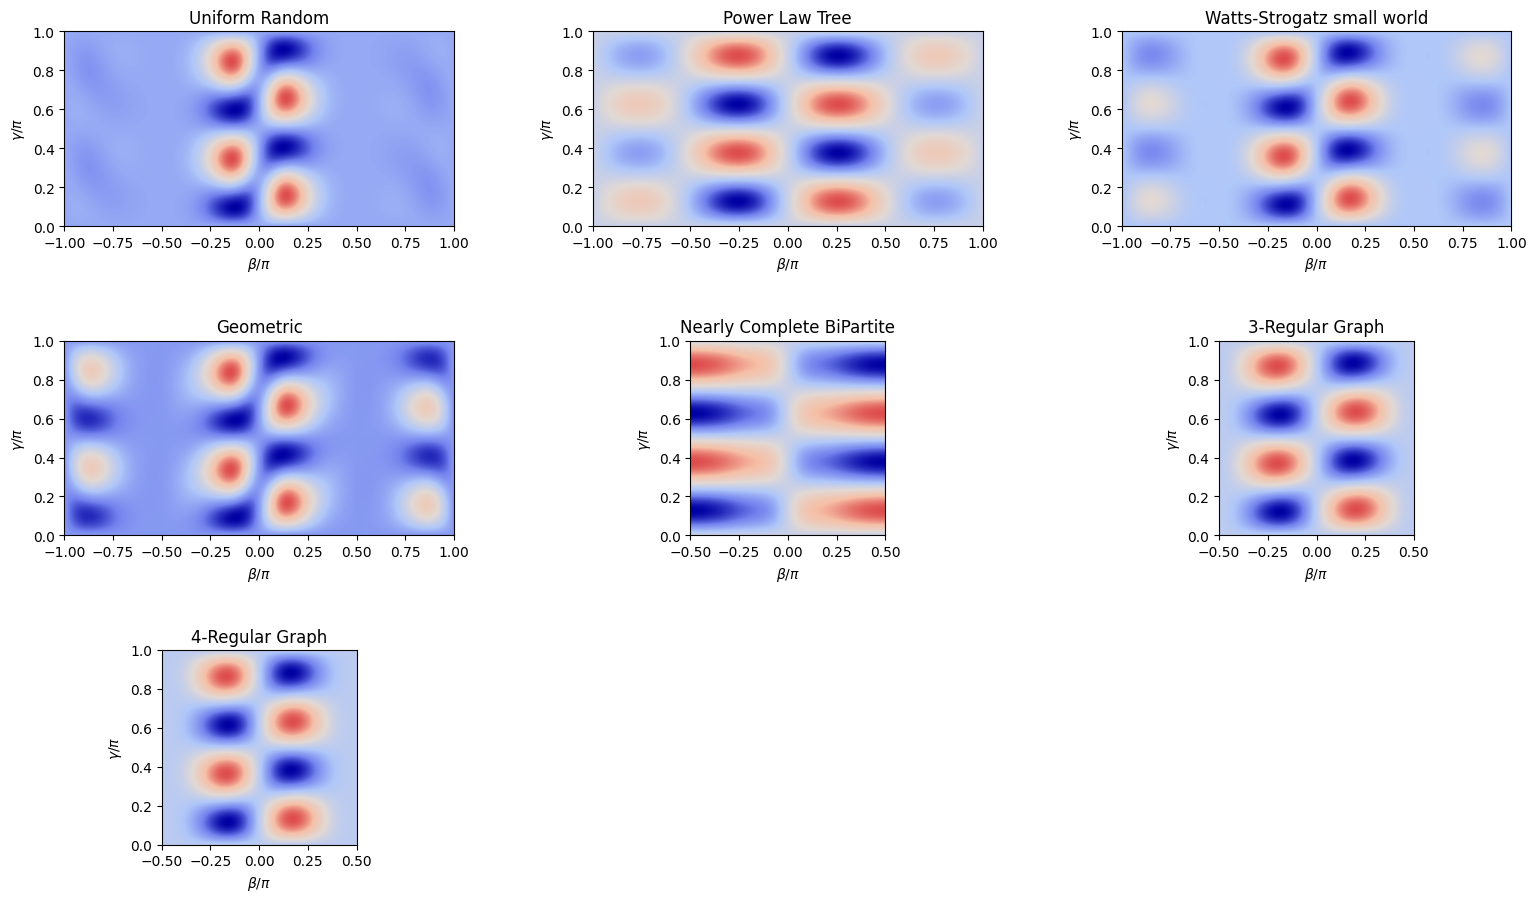

In [3]:
# Create a figure with a grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(16,9))

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Loop through the stored landscape data and create subplots
for idx, (graph_key, landscape_data) in enumerate(d_landscape.items()):
    if graph_key != "Graph_8_4-Regular Graph Fixed Weights":
        ax = axs[idx]

        # Extract data for plotting
        beta = landscape_data['beta']/ np.pi
        gamma = landscape_data['gamma']/ np.pi
        obj_vals = landscape_data['obj_vals']
        
        # Custom Cmap
        colors = [
            "#0000A3",
            "#7282ee",
            "#B0C7F9",
            "#e2d9d4",
            "#F6BFA6",
            "#de4d4d",
        ]
        
        custom_cmap = LinearSegmentedColormap.from_list("custom_red_blue_darker_ends", colors, N=256)

    #     # Plotting the data
        im = ax.imshow(obj_vals.T, origin='lower', cmap=custom_cmap, extent=(beta[0], beta[-1], gamma[0], gamma[-1]))
        ax.set_xlabel(r'$\beta / \pi$')
        ax.set_ylabel(r'$\gamma / \pi$')
        title = '_'.join(graph_key.split('_')[2:])
        ax.set_title(f"{title}")

# # Remove unused axes if the number of plots is less than the number of subplots
for idx in range(len(d_landscape)-1, len(axs)):
    fig.delaxes(axs[idx])
    axs[idx].set_visible(False)  # This will ensure the axis is not visible at all

# # Adjust the layout of the subplots, adding more space between them
# Adjust the layout of the subplots, reducing the vertical space between them
fig.tight_layout(pad=1.0, h_pad=4, w_pad=1.0)  # Adjust h_pad for vertical spacing


# # Save the entire grid plot
plt.savefig("landscape_grid.png", dpi=300)


Text(0.5, 1.0, '2 Regular Graph')

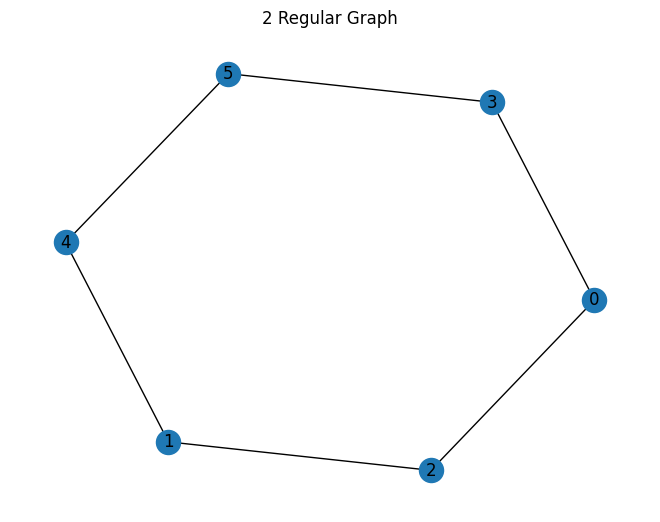

In [24]:
# Generate a network graph (2-regular instance) and  Ensure that the graph is connected
G = nx.random_regular_graph(2, 6)
while not nx.is_connected(G):
    G = nx.random_regular_graph(2, 6)

nx.draw(G, with_labels=True)
plt.title("2 Regular Graph")

In [25]:
# Generate the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G)
max_cut = Maxcut(adjacency_matrix)
qubitOp, offset = max_cut.to_quadratic_program().to_ising()

# Brute Force Solution for Max-Cut Problem
print(f"\n{'-'*10} Solving for Exact Ground State {'-'*10}\n")
max_cut_partition, max_cut_value = compute_max_cut_brute_force(G)
print(f"MAXCUT Paritition: {max_cut_partition}")
print(f"MAXCUT Value: {max_cut_value}")

# Solve the problem using the NumPyMinimumEigensolver
exact_eigensolver = NumPyMinimumEigensolver()
exact_result = exact_eigensolver.compute_minimum_eigenvalue(qubitOp)
print(f"Exact Solution: {exact_result.eigenvalue}")

# Solve the problem using the QAOA
optimizer = SLSQP()
qaoa = QAOA(optimizer=optimizer, reps=1, quantum_instance=Aer.get_backend('qasm_simulator'))
result = qaoa.compute_minimum_eigenvalue(qubitOp)
print(f"QAOA Solution: {result.eigenvalue}")

# Calculate the approximation ratio
approximation_ratio = result.eigenvalue / exact_result.eigenvalue
print(f"Approximation Ratio: {approximation_ratio}")

/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_59122/631649606.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)



---------- Solving for Exact Ground State ----------

MAXCUT Paritition: (1, 0, 5)
MAXCUT Value: 6
Exact Solution: (-3+0j)
QAOA Solution: (-0.12890624999999997+0j)
Approximation Ratio: (0.042968749999999986-0j)


/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [26]:
def build_landscape_plot(
    G, 
    mesh_size: int = 10, 
    beta_lb: float = -2 * np.pi, 
    beta_ub: float = 2 * np.pi, 
    gamma_lb: float = -2 * np.pi, 
    gamma_ub: float = 2 * np.pi,
    layers: int = 1,
    **kwargs
) -> dict:
    """
    Build a landscape plot for the QAOA applied to the Maxcut problem on a given graph.

    Parameters:
    G : networkx.Graph
        The graph for which the QAOA landscape is being computed.
    mesh_size : int
        The number of points in the mesh grid for beta and gamma.
    beta_lb : float, default -2*pi
        The lower bound for the beta parameter.
    beta_ub : float, default 2*pi
        The upper bound for the beta parameter.
    gamma_lb : float, default -2*pi
        The lower bound for the gamma parameter.
    gamma_ub : float, default 2*pi
        The upper bound for the gamma parameter.
    layers : int, default 1
        Number of QAOA layers
        
    Returns:
    dict
        A dictionary containing the beta, gamma, and objective values for the QAOA applied to Maxcut.
    """
    # Convert graph to adjacency matrix and setup Maxcut
    adjacency_matrix = nx.adjacency_matrix(G)
    max_cut = Maxcut(adjacency_matrix)
    qubitOp, offset = max_cut.to_quadratic_program().to_ising()

    # Define QAOA parameters
    beta = ParameterVector('β', length=layers)
    gamma = ParameterVector('γ', length=layers)
    
    # If layers > 1 then fix those layers
    if layers > 1:
        # Check **kwargs if fixed values exist
        if 'fixed_betas' in kwargs and 'fixed_gammas' in kwargs:
            fixed_betas = kwargs['fixed_betas']
            fixed_gammas = kwargs['fixed_gammas']
        else:
            raise TypeError("Provide Fixed Values for Beta and Gamma as a List")
        

    # Initialize the QAOA circuit with the parameters
    qaoa = QAOA(optimizer=SLSQP(), reps=layers, initial_point=[beta, gamma])

    # Create linspace for beta and gamma
    beta_vals = np.linspace(beta_lb, beta_ub, mesh_size)
    gamma_vals = np.linspace(gamma_lb, gamma_ub, mesh_size)
    
    # Check if layers > 1
    if layers > 1:
        obj_vals = parallel_computation_n_layers_fixed(beta_vals, gamma_vals, fixed_betas, fixed_gammas, qubitOp, qaoa)
    else:
        obj_vals = parallel_computation(beta_vals, gamma_vals, qubitOp, qaoa)
    
    return {'beta': beta_vals, 'gamma': gamma_vals, 'obj_vals': obj_vals}

def plot_landscape(landscape_data, ax=None, **kwargs):
    colors = [
        "#0000A3",
        "#7282ee",
        "#B0C7F9",
        "#e2d9d4",
        "#F6BFA6",
        "#de4d4d",
    ]
    custom_cmap = LinearSegmentedColormap.from_list("custom_red_blue_darker_ends", colors, N=256)

    beta = landscape_data['beta'] / np.pi
    gamma = landscape_data['gamma'] / np.pi
    obj_vals = landscape_data['obj_vals']

    # Create a new figure if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        show_colorbar = True
    else:
        show_colorbar = 'colorbar' in kwargs and kwargs['colorbar']

    im = ax.imshow(
        obj_vals.T,
        origin='lower',
        cmap=custom_cmap,
        extent=(beta[0], beta[-1], gamma[0], gamma[-1]),
    )

    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$\gamma$')

    beta_ticks = np.linspace(beta[0], beta[-1], 5)
    gamma_ticks = np.linspace(gamma[0], gamma[-1], 5)
    ax.set_xticks(beta_ticks)
    ax.set_yticks(gamma_ticks)

    if 'source' in kwargs:
        ax.set_title(kwargs['source'])

    if 'point' in kwargs:
        point = kwargs['point']
        point = (point[0] / np.pi, point[1] / np.pi)
        ax.plot(point[0], point[1], 'r*')

    if show_colorbar:
        plt.colorbar(im, ax=ax)

    if ax is None:
        plt.show()

/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_59122/2648308776.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:27<00:00, 48.24it/s]


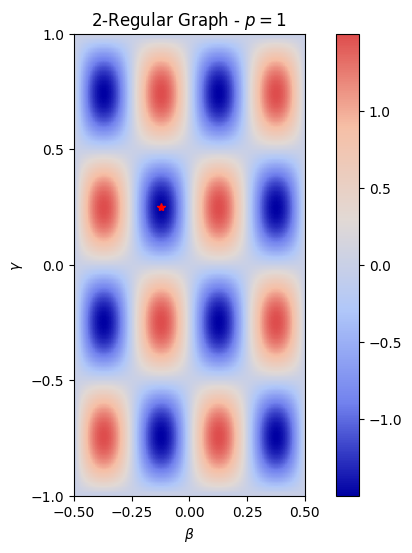

In [27]:
landscape_data_storage = build_landscape_plot(
    G, 
    mesh_size=100, 
    beta_lb=-np.pi/2, 
    beta_ub=np.pi/2, 
    gamma_lb=-np.pi, 
    gamma_ub=np.pi, 
    layers=1,
    fixed_betas = [np.pi/8],
    fixed_gammas = [-np.pi/4]
)

plot_landscape(landscape_data_storage, point = [-np.pi/8, np.pi/4], source="2-Regular Graph - $p=1$")

## Understanding our instances

Lets consider the following instances that we study:

In [8]:
node_size = 6
G = nx.Graph()

# Add 6 nodes
G.add_nodes_from(range(node_size))

# Add edges to make it 3-regular without triangles
# Forming a cycle
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)])
# Adding edges to form a perfect matching, avoiding triangles
G.add_edges_from([(0, 3), (1, 4), (2, 5)])

G_three_reg_no_triangles = GraphInstance(G, graph_type="3-Regular (no triangle)")

# Generate a network graph (2-regular instance) and  Ensure that the graph is connected
G = nx.random_regular_graph(2, node_size)
while not nx.is_connected(G):
    G = nx.random_regular_graph(2, node_size)
    
G_two_reg = GraphInstance(G, graph_type="2-Regular (ring)")

Guess 1 for producing a connected Geometric Graph with r=0.552319036029318 - connected: False
Guess 2 for producing a connected Geometric Graph with r=0.7185142484298308 - connected: True


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_59122/3724727218.py:35: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  ax.set_title(f"{graph_type}\n{nx.info(G)}", size=10)


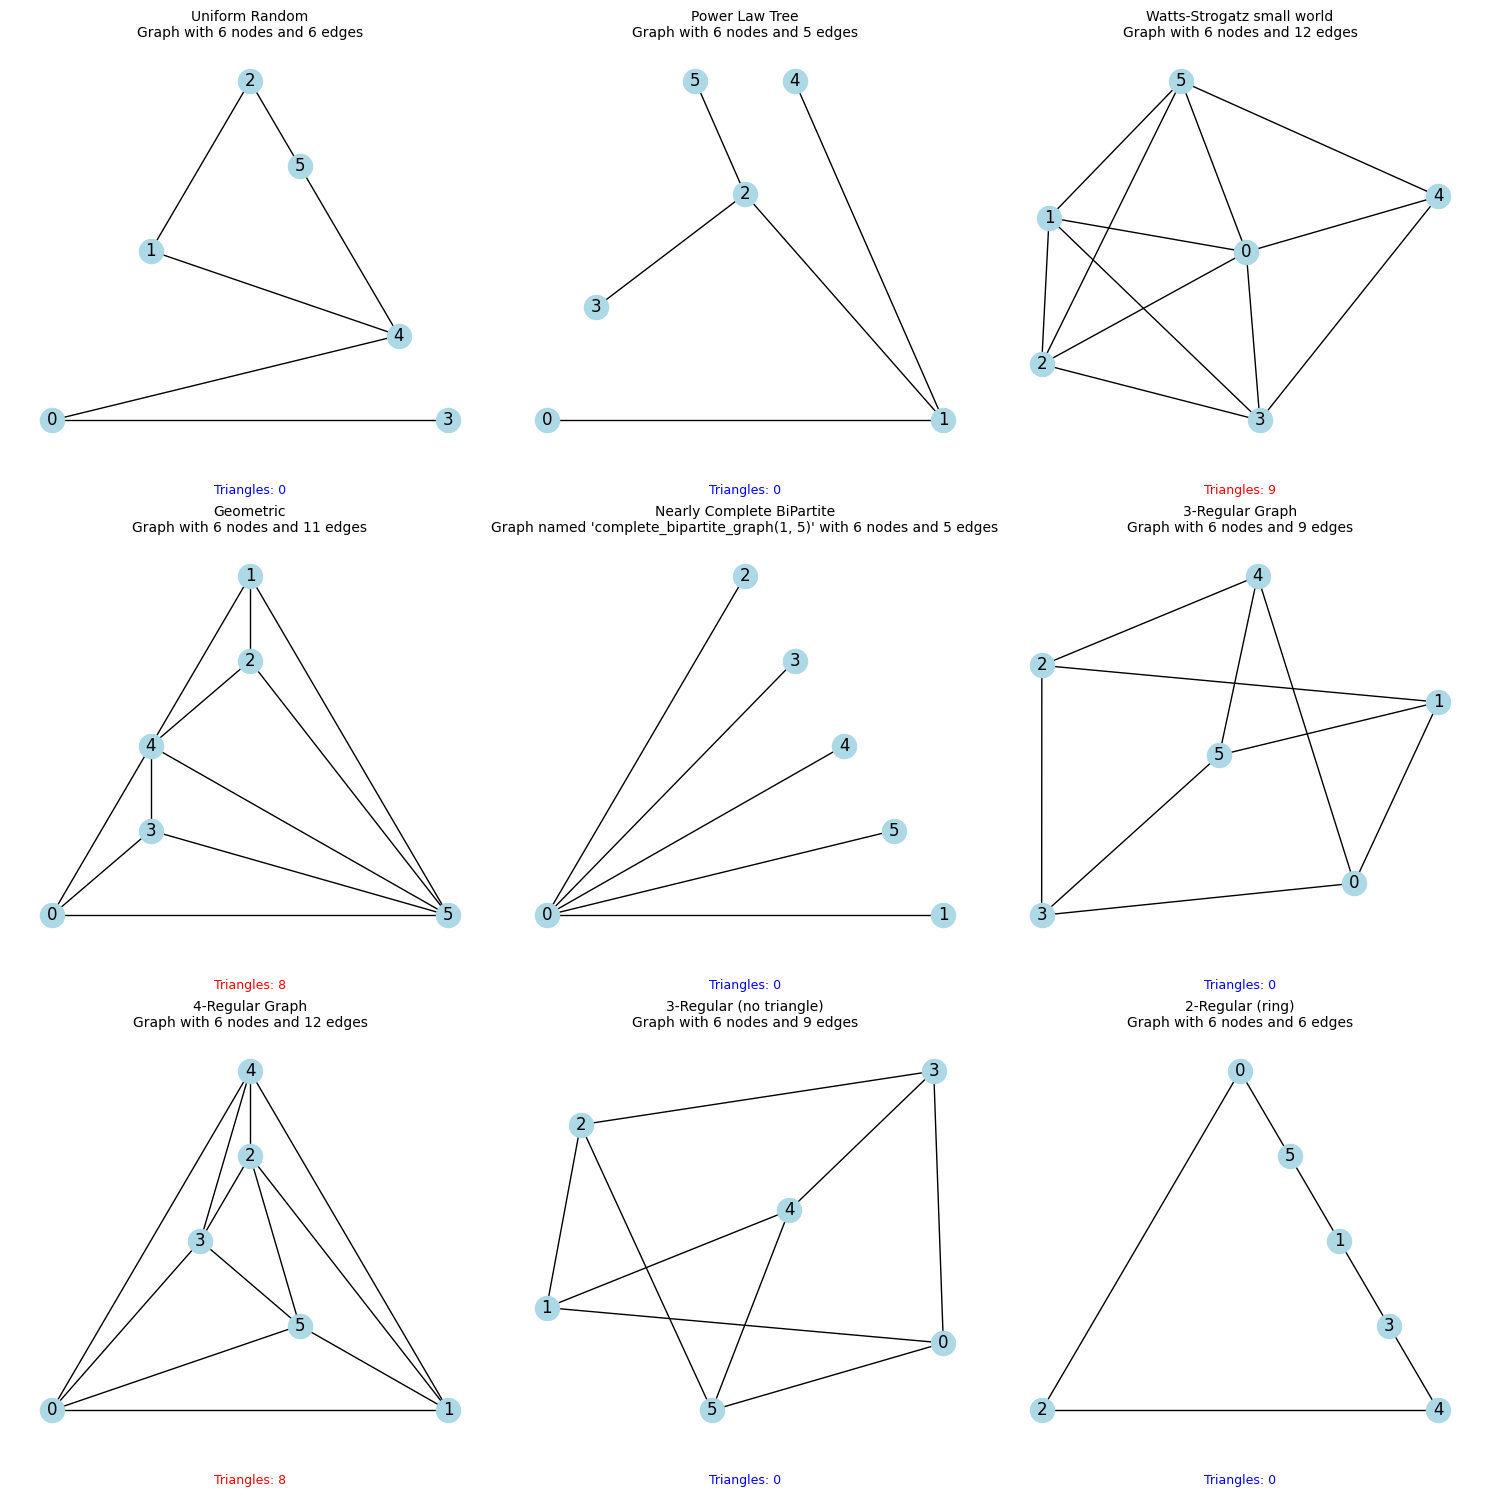

In [17]:
G_instances = create_graphs_from_all_sources(node_size)
G_instances.pop()
G_instances.append(G_three_reg_no_triangles)
G_instances.append(G_two_reg)



# Assuming G_instances is a list of objects with .G and .graph_type attributes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15)) # Adjust nrows and ncols based on your list size
axes = axes.flatten() # Flatten the 2D array of axes to easily loop over it

for i, ax in enumerate(axes):
    if i >= len(G_instances):
        ax.axis('off') # Turn off axes for any subplots beyond the number of graphs
        continue
    G = G_instances[i].G
    graph_type = G_instances[i].graph_type

    try:
        # Check if the graph is planar and get the embedding if it is
        _, pos = nx.check_planarity(G, counterexample=False)
        pos = nx.planar_layout(G) # Use planar layout if graph is planar
    except nx.NetworkXException:
        pos = nx.spring_layout(G) # Use spring layout as a fallback
    
    # Calculate number of triangles
    total_triangles = sum(nx.triangles(G).values()) // 3

    # Determine node color based on the presence of triangles
    text_color = 'red' if total_triangles > 0 else 'blue'
    
    nx.draw(G, pos, ax=ax, with_labels=True, node_color="lightblue")
    
    # Annotating the graph type, info, and number of triangles below each chart
    ax.set_title(f"{graph_type}\n{nx.info(G)}", size=10)
    ax.text(0.5, -0.1, f"Triangles: {total_triangles}", size=9, va='bottom', ha='center', transform=ax.transAxes, color=text_color)

plt.tight_layout()
plt.show()


In [28]:
landscape_data = []
for graph in G_instances:
    d_landscape = build_landscape_plot(
        graph.G,
        beta_lb=-np.pi/2, 
        beta_ub=np.pi/2, 
        gamma_lb = -np.pi,
        gamma_ub = np.pi,
        mesh_size=100,
    )
    landscape_data.append(
        {
            "graph_type": graph.graph_type,
            "landscape_data": d_landscape,
            "graph": graph
        }
    )

/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_59122/2648308776.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:30<00:00, 47.58it/s]
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_59122/2648308776.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:35<00:00, 29.79it/s]
/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_59122/2648308776.py:35: FutureWarning: adjacency_matrix

In [29]:
import pickle
with open('ml-model-landscape.pkl', 'wb') as f:
    pickle.dump(landscape_data, f)

In [36]:
def calculate_optimal_angles_for_triangle_free_graph(G):
    """
    Calculate the optimal angles γ*, β* for an arbitrary triangle-free graph within the range [0, π/2],
    with β* potentially fixed at π/8 depending on the regularity of the graph.

    Parameters:
    G : networkx.Graph
        The graph for which to calculate the angles.

    Returns:
    optimal_angles : list of tuples
        A list containing tuples of optimal pairs of angles for the triangle-free graph.
    """
    
    # Check if the graph is triangle-free
    if sum(nx.triangles(G).values()) != 0:
        return None

    # Get the maximum and minimum degree of the graph
    degrees = [degree for node, degree in G.degree()]
    D_max = max(degrees)
    D_min = min(degrees)
    
    optimal_angles = []

    # Case for D-regular graph
    if len(set(degrees)) == 1:  # Check if the graph is regular
        D = D_max  # Since the graph is regular, all degrees are the same
        gamma_star = np.arctan(1 / np.sqrt(D - 1))
        beta_star = -np.pi / 8
    
    # Case for arbitrary triangle-free graph
    else:
        # Lower bound for γ* based on D_max
        if D_max == 1:
            gamma_star_lb = 0
        else:
            gamma_star_lb = np.arctan(1 / np.sqrt(D_max - 1))

        # Upper bound for γ* based on D_min
        if D_min == 1:
            gamma_star_ub = np.pi / 2
        else:
            gamma_star_ub = np.arctan(1 / np.sqrt(D_min - 1))
            
        
        # Sample gamma_star from the range
        gamma_star = np.random.uniform(gamma_star_lb, gamma_star_ub)
        beta_star = -np.pi / 8
        
    return beta_star, gamma_star

This is a Uniform Random Graph with 6 nodes and 6 edges graph instance
(-0.39269908169872414, 0.6523026840303465)
This is a Power Law Tree Graph with 6 nodes and 5 edges graph instance
(-0.39269908169872414, 1.053830942673751)
This is a Watts-Strogatz small world Graph with 6 nodes and 12 edges graph instance
None
This is a Geometric Graph with 6 nodes and 11 edges graph instance
None
This is a Nearly Complete BiPartite Graph named 'complete_bipartite_graph(1, 5)' with 6 nodes and 5 edges graph instance
(-0.39269908169872414, 0.7849277918850076)
This is a 3-Regular Graph Graph with 6 nodes and 9 edges graph instance
(-0.39269908169872414, 0.6154797086703873)
This is a 4-Regular Graph Graph with 6 nodes and 12 edges graph instance
None
This is a 3-Regular (no triangle) Graph with 6 nodes and 9 edges graph instance
(-0.39269908169872414, 0.6154797086703873)
This is a 2-Regular (ring) Graph with 6 nodes and 6 edges graph instance
(-0.39269908169872414, 0.7853981633974483)


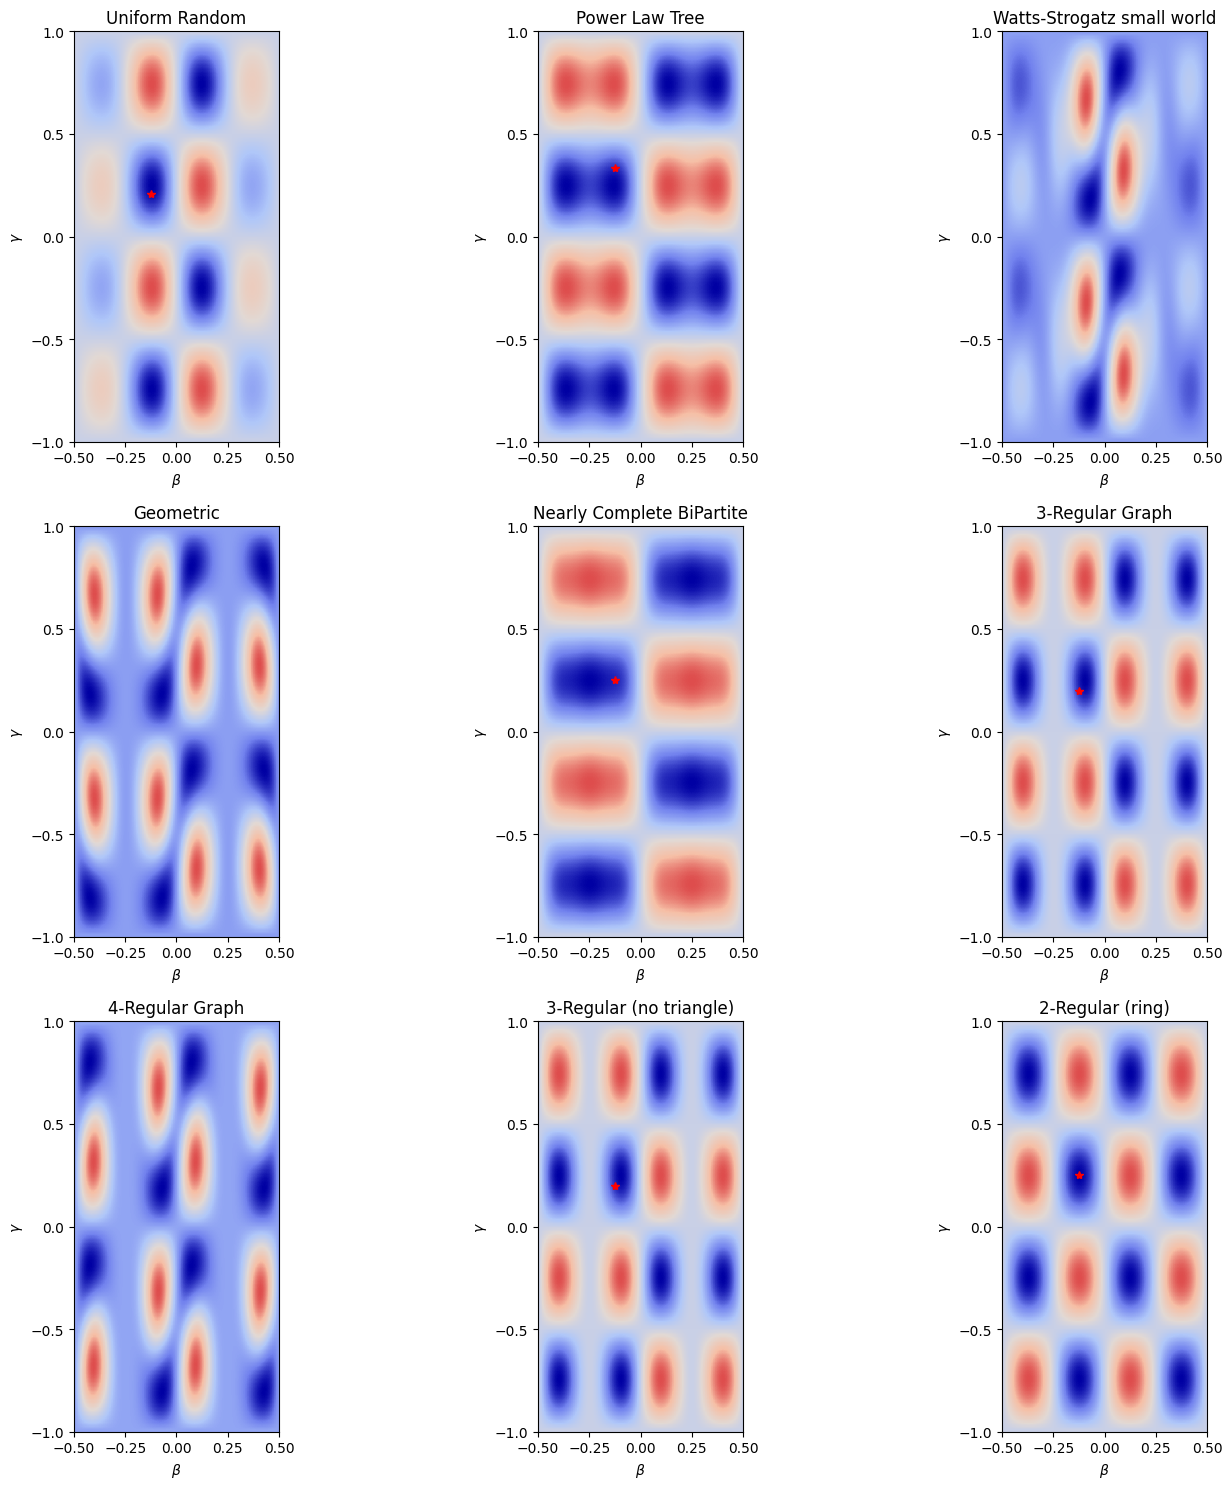

In [37]:
# Assume landscape_data is a list of dicts with 'graph' and 'landscape_data' keys
num_instances = len(landscape_data)
num_rows = int(np.ceil(np.sqrt(num_instances)))
num_cols = num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
axes = axes.flatten()

for idx, inst in enumerate(landscape_data):
    print(inst["graph"])
    point = calculate_optimal_angles_for_triangle_free_graph(inst["graph"].G)
    print(point)
    ax = axes[idx]
    if point is not None:

        plot_landscape(
            inst["landscape_data"], 
            ax=ax,
            point=[point[0], point[1]], 
            source=inst["graph"].graph_type
        )
    else:
        # Handle the case where the graph is not triangle-free or not regular
        plot_landscape(
            inst["landscape_data"],
            ax=ax,
 #           point=[np.pi, 0.2],
            source=inst["graph"].graph_type
        )
    # Only add a colorbar to the last plot to avoid clutter
    if idx == num_instances - 1:
        plot_landscape(
            inst["landscape_data"],
            ax=ax,
#            point=[np.pi, 0.2],
            source=inst["graph"].graph_type,
            colorbar=False
        )

# Turn off any unused subplots
for ax in axes[num_instances:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
